##Graphs for metals stacked##
based on scraped by-metal data in data/<metal_name>

Edited: 5/23

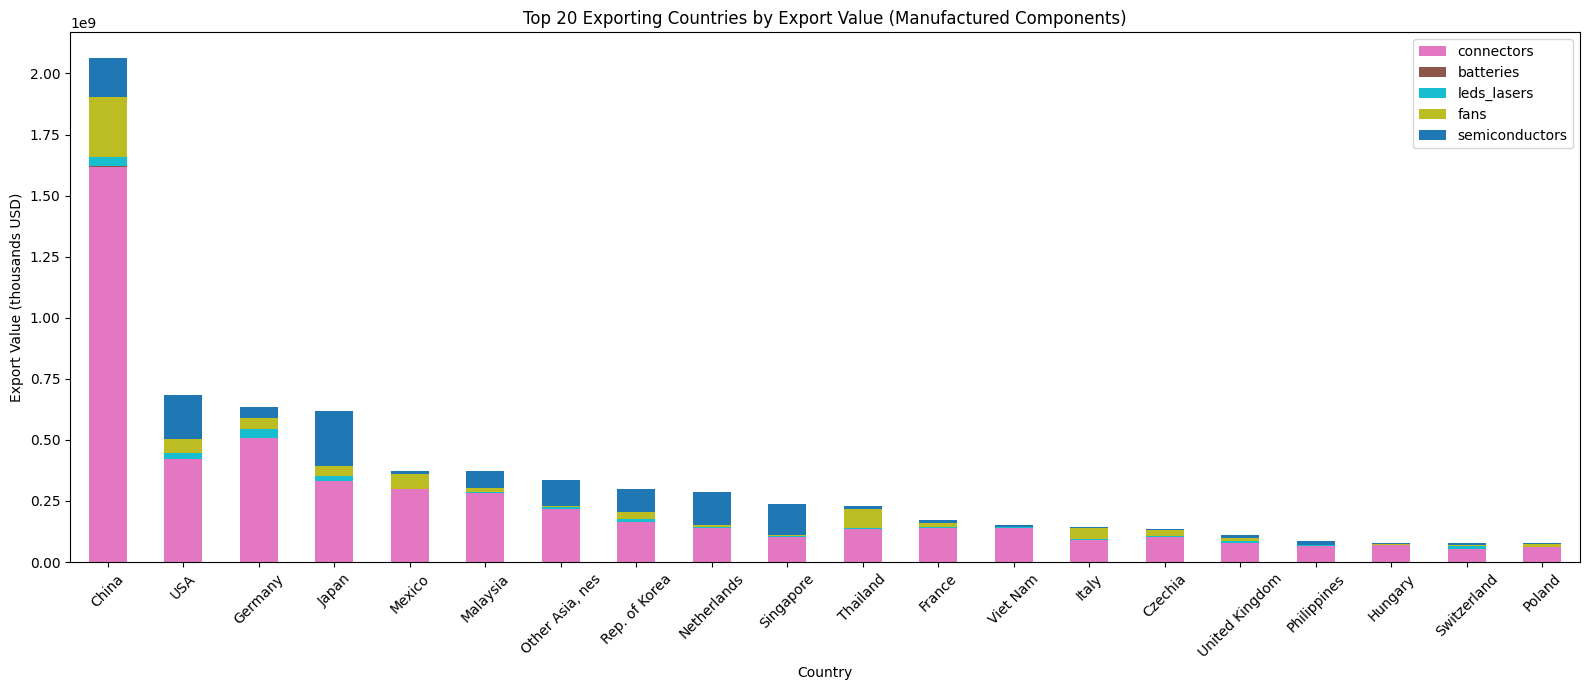

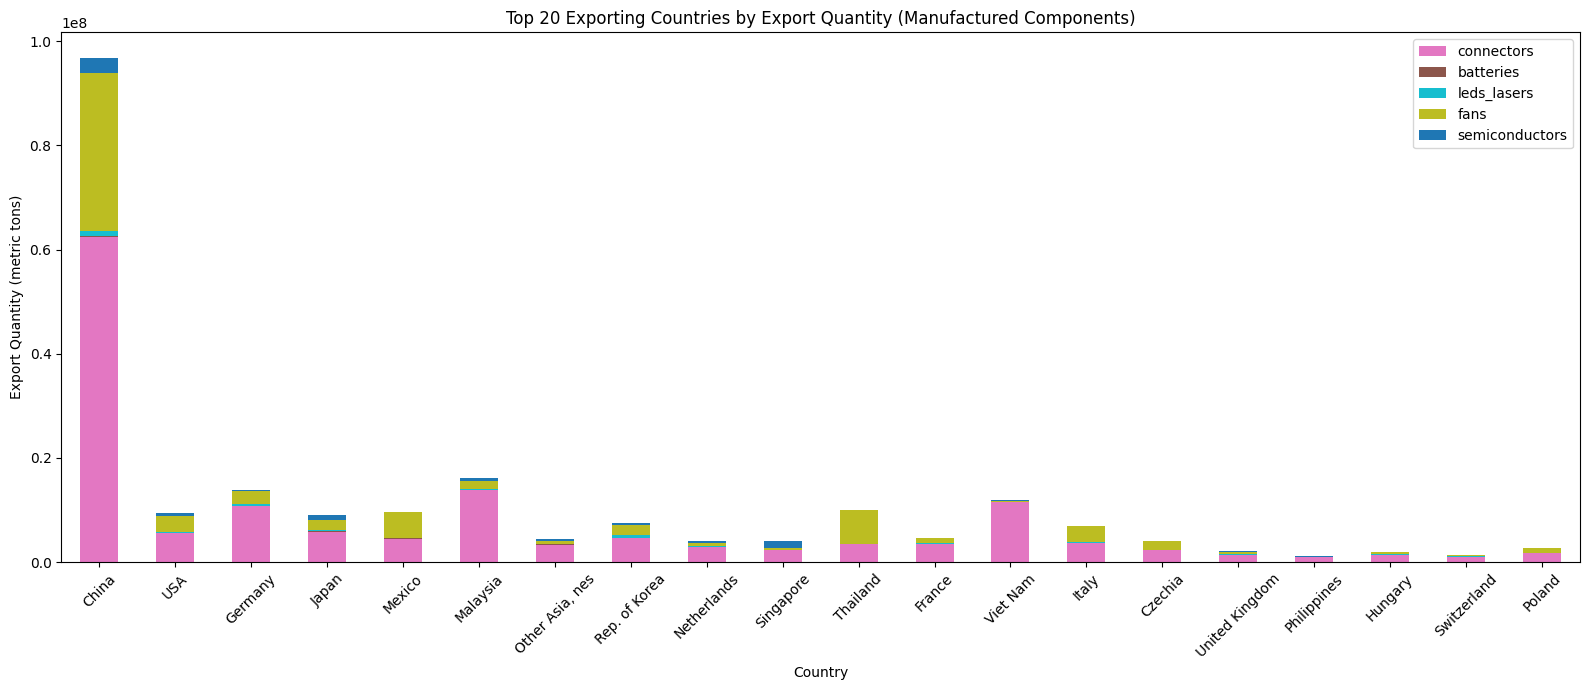

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# === CONFIGURATION ===
base_dir = "../data/manufacturing"
country_code_file = "../ref/country_codes_V202501.csv"
category_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

# Load country codes
country_df = pd.read_csv(country_code_file)
country_lookup = dict(zip(country_df["country_code"], country_df["country_name"]))

# Assign colors to manufacturing categories
category_colors = {
    "semiconductors": "#1f77b4",
    "pcbs": "#ff7f0e",
    "capacitors": "#2ca02c",
    "resistors": "#d62728",
    "power_supplies": "#9467bd",
    "batteries": "#8c564b",
    "connectors": "#e377c2",
    "storage_devices": "#7f7f7f",
    "fans": "#bcbd22",
    "leds_lasers": "#17becf"
}

# === DATA STRUCTURES ===
export_value = defaultdict(lambda: defaultdict(float))
export_quantity = defaultdict(lambda: defaultdict(float))

# === LOAD TRADE DATA ===
for category in category_dirs:
    trade_path = os.path.join(base_dir, category, "trade_data.csv")
    if not os.path.exists(trade_path):
        continue

    try:
        df = pd.read_csv(trade_path)
        df = df.rename(columns={"i": "exporter", "j": "importer", "k": "hs_code", "v": "value", "q": "quantity"})

        grouped = df.groupby("exporter").agg({"value": "sum", "quantity": "sum"}).reset_index()

        for _, row in grouped.iterrows():
            export_value[int(row["exporter"])][category] += row["value"]
            export_quantity[int(row["exporter"])][category] += row["quantity"]

    except Exception as e:
        print(f"[ERROR] Failed to process {category}: {e}")

# === CONSTRUCT DATAFRAMES ===
value_df = pd.DataFrame(export_value).T.fillna(0)
quantity_df = pd.DataFrame(export_quantity).T.fillna(0)

# Map exporter codes to country names
value_df.index = value_df.index.map(lambda x: country_lookup.get(x, f"Code {x}"))
quantity_df.index = quantity_df.index.map(lambda x: country_lookup.get(x, f"Code {x}"))

# Identify top 20 exporters by total export value
total_value = value_df.sum(axis=1)
top_exporters = total_value.nlargest(20).index

# Filter top exporter rows
value_df_top = value_df.loc[top_exporters]
quantity_df_top = quantity_df.loc[top_exporters]

# Validate columns for coloring
valid_categories = [col for col in value_df_top.columns if col in category_colors]
colors = [category_colors[c] for c in valid_categories]

# === PLOT EXPORT VALUE ===
fig, ax = plt.subplots(figsize=(16, 7))
value_df_top[valid_categories].plot(kind="bar", stacked=True, color=colors, ax=ax)
ax.set_title("Top 20 Exporting Countries by Export Value (Manufactured Components)")
ax.set_ylabel("Export Value (thousands USD)")
ax.set_xlabel("Country")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# === PLOT EXPORT QUANTITY ===
fig, ax = plt.subplots(figsize=(16, 7))
quantity_df_top[valid_categories].plot(kind="bar", stacked=True, color=colors, ax=ax)
ax.set_title("Top 20 Exporting Countries by Export Quantity (Manufactured Components)")
ax.set_ylabel("Export Quantity (metric tons)")
ax.set_xlabel("Country")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


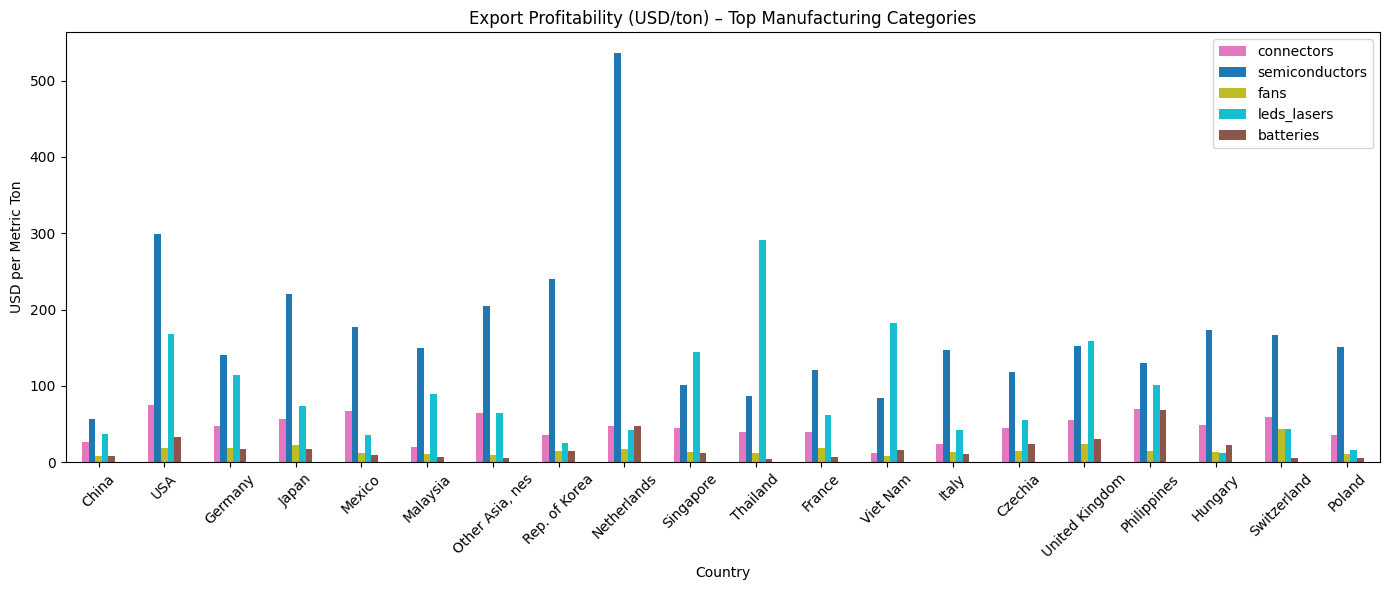

In [3]:
# === USD PER TON ANALYSIS FOR MANUFACTURING ===
quantity_df_clean = quantity_df.replace(0, float('nan'))  # avoid division by 0
value_per_ton_df = value_df / quantity_df_clean

# Restrict to top exporters
value_per_ton_top = value_per_ton_df.loc[top_exporters]

# Identify top manufacturing categories by total value
top_categories = value_df[valid_categories].sum().nlargest(5).index.tolist()
top_colors = [category_colors[m] for m in top_categories]

# === PLOT EXPORT PROFITABILITY ===
fig, ax = plt.subplots(figsize=(14, 6))
value_per_ton_top[top_categories].plot(kind="bar", ax=ax, color=top_colors)
ax.set_title("Export Profitability (USD/ton) – Top Manufacturing Categories")
ax.set_ylabel("USD per Metric Ton")
ax.set_xlabel("Country")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


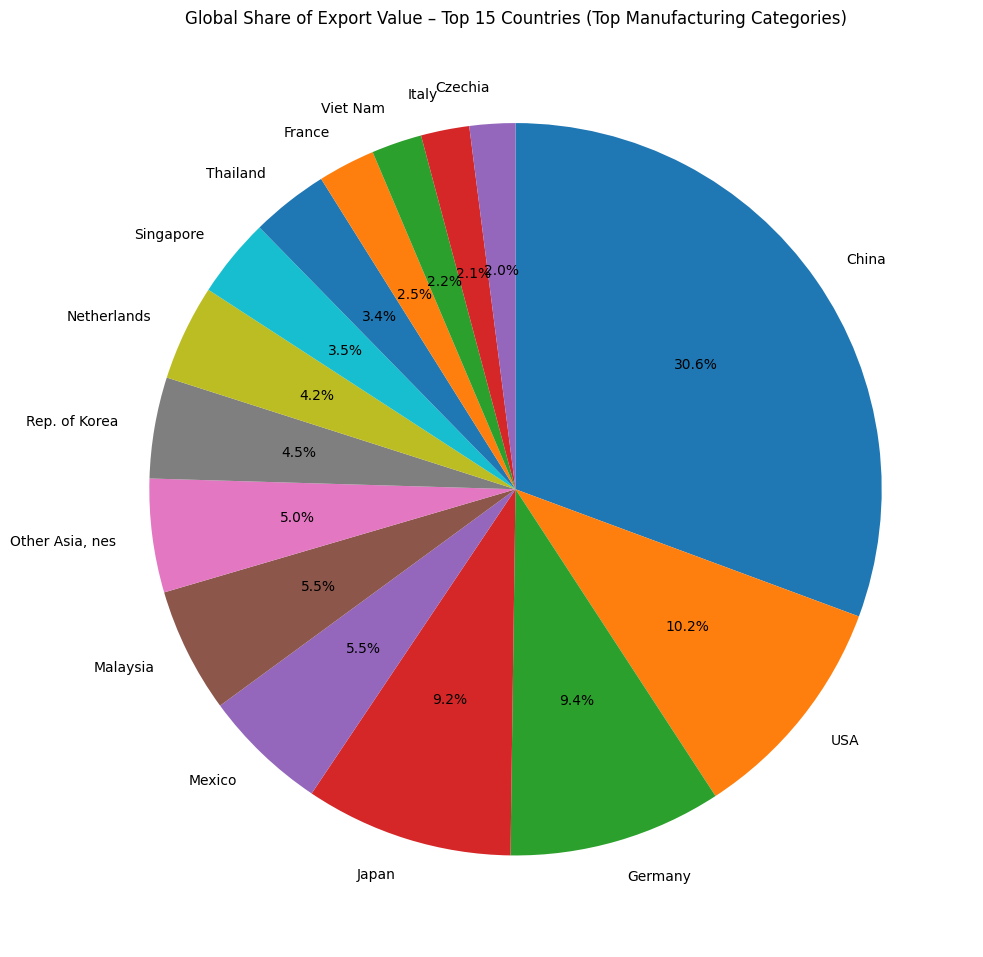

In [4]:
# === GLOBAL SHARE OF EXPORT VALUE (MANUFACTURING) ===
global_total_value = value_df[valid_categories].sum().sum()
share_value = value_df[valid_categories].sum(axis=1) / global_total_value * 100
share_value_top = share_value[top_exporters[:15]]  # Top 15 exporters

fig, ax = plt.subplots(figsize=(10, 10))
ax.pie(
    share_value_top,
    labels=share_value_top.index,
    autopct="%1.1f%%",
    startangle=90,
    counterclock=False,
)
ax.set_title("Global Share of Export Value – Top 15 Countries (Top Manufacturing Categories)")
plt.tight_layout()
plt.show()


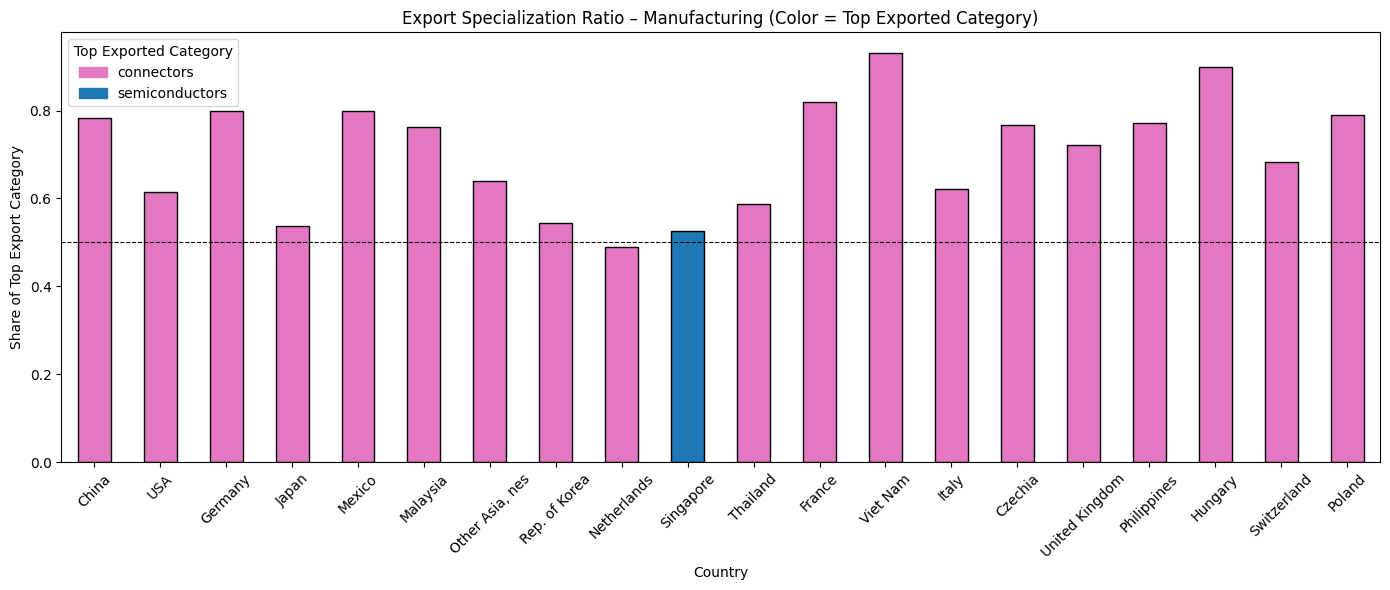

In [5]:
# === MANUFACTURING CATEGORY CONCENTRATION ===
concentration_ratio = value_df[valid_categories].div(value_df[valid_categories].sum(axis=1), axis=0)
max_share_per_country = concentration_ratio.max(axis=1)
top_category_per_country = concentration_ratio.idxmax(axis=1)

# Map colors to top categories per country
bar_colors = top_category_per_country[top_exporters].map(category_colors)

# === PLOT MANUFACTURING SPECIALIZATION ===
fig, ax = plt.subplots(figsize=(14, 6))
max_share_per_country[top_exporters].plot(
    kind='bar',
    ax=ax,
    color=bar_colors,
    edgecolor='black'
)

# Set up custom legend
unique_categories = sorted(set(top_category_per_country[top_exporters]))
handles = [plt.Rectangle((0, 0), 1, 1, color=category_colors[cat]) for cat in unique_categories]
ax.legend(handles, unique_categories, title="Top Exported Category")

ax.set_title("Export Specialization Ratio – Manufacturing (Color = Top Exported Category)")
ax.set_ylabel("Share of Top Export Category")
ax.set_xlabel("Country")
plt.axhline(0.5, color="black", linestyle="--", linewidth=0.8)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


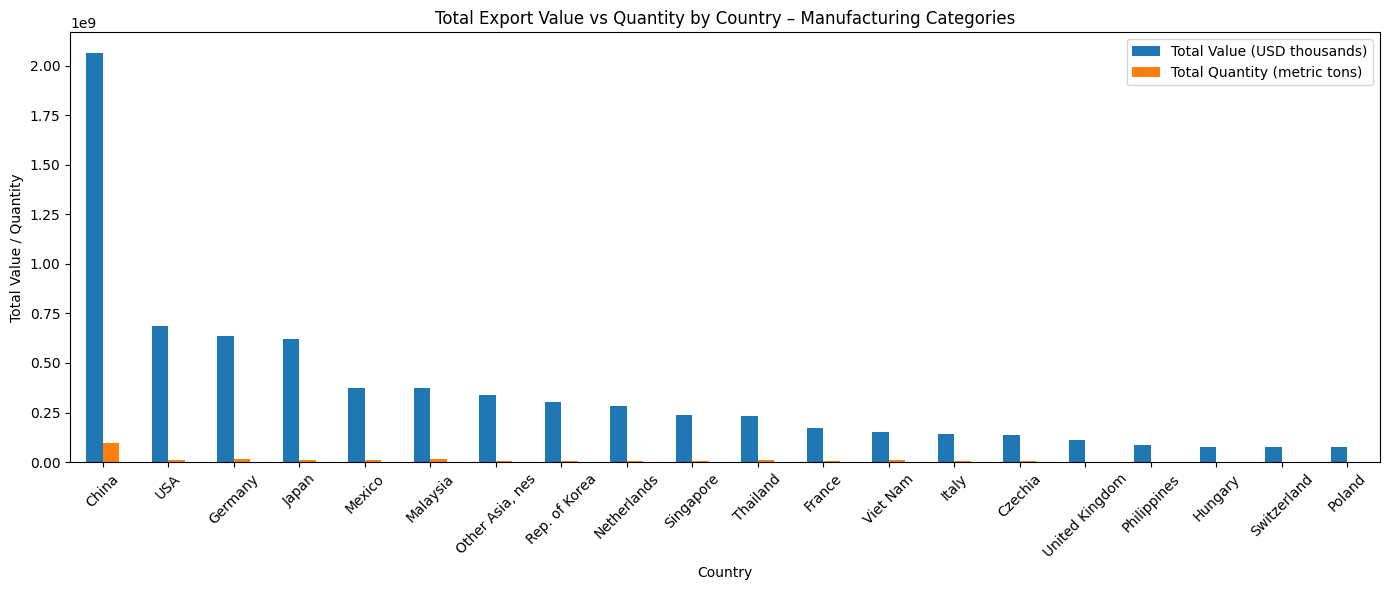

In [6]:
# === EXPORT VALUE VS QUANTITY: MANUFACTURING ===
# Compute total value and quantity for manufacturing categories
total_val = value_df[valid_categories].sum(axis=1)
total_qty = quantity_df[valid_categories].sum(axis=1)

# Build comparison DataFrame
comparison_df = pd.DataFrame({
    "Total Value (USD thousands)": total_val[top_exporters],
    "Total Quantity (metric tons)": total_qty[top_exporters]
})

# Plotting
fig, ax = plt.subplots(figsize=(14, 6))
comparison_df.plot(kind="bar", ax=ax)
ax.set_title("Total Export Value vs Quantity by Country – Manufacturing Categories")
ax.set_ylabel("Total Value / Quantity")
ax.set_xlabel("Country")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
